<a href="https://colab.research.google.com/github/Svhugani/CryptoAnalysis/blob/main/BITCOIN_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1. Bit coin analysis**

In [31]:
import math
import numpy as np
import pandas as pd
import pandas_datareader as web
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LSTM, Conv1D, Flatten, Dropout, GlobalMaxPooling1D, MaxPool1D, BatchNormalization
import matplotlib.pyplot as plt
import tensorflow as tf
from scipy.stats import norm
from scipy.stats import t as tstudent
from scipy.stats import probplot
plt.style.use('dark_background')

In [32]:
START_DATE = '2010-01-01'
END_DATE = '2021-02-10'
ASSET = 'BTC-USD'

In [33]:
df = web.DataReader(ASSET, data_source = 'yahoo', start = START_DATE , end = END_DATE)

In [34]:
df.head(10)

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2014-09-16,468.174011,452.421997,465.864014,457.334015,21056800.0,457.334015
2014-09-17,456.859985,413.104004,456.859985,424.440002,34483200.0,424.440002
2014-09-18,427.834991,384.532013,424.102997,394.795990,37919700.0,394.795990
2014-09-19,423.295990,389.882996,394.673004,408.903992,36863600.0,408.903992
2014-09-20,412.425995,393.181000,408.084991,398.821014,26580100.0,398.821014
2014-09-21,406.915985,397.130005,399.100006,402.152008,24127600.0,402.152008
2014-09-22,441.557007,396.196991,402.092010,435.790985,45099500.0,435.790985
2014-09-23,436.112000,421.131989,435.751007,423.204987,30627700.0,423.204987
2014-09-24,423.519989,409.467987,423.156006,411.574005,26814400.0,411.574005


In [35]:
# Add % change and log-% change
df['prev_Close'] = df['Close'].shift(1)
df['return'] = (df['Close'] - df['prev_Close']) / df['Close']
df['log_return'] = np.log(df['return'] + 1)
df.head(5)

,High,Low,Open,Close,Volume,Adj Close,prev_Close,return,log_return
Date,,,,,,,,,
2014-09-16,468.174011,452.421997,465.864014,457.334015,21056800.0,457.334015,NaN,NaN,NaN
2014-09-17,456.859985,413.104004,456.859985,424.440002,34483200.0,424.440002,457.334015,-0.077500,-0.080668
2014-09-18,427.834991,384.532013,424.102997,394.795990,37919700.0,394.795990,424.440002,-0.075087,-0.078056
2014-09-19,423.295990,389.882996,394.673004,408.903992,36863600.0,408.903992,394.795990,0.034502,0.033920
2014-09-20,412.425995,393.181000,408.084991,398.821014,26580100.0,398.821014,408.903992,-0.025282,-0.025607


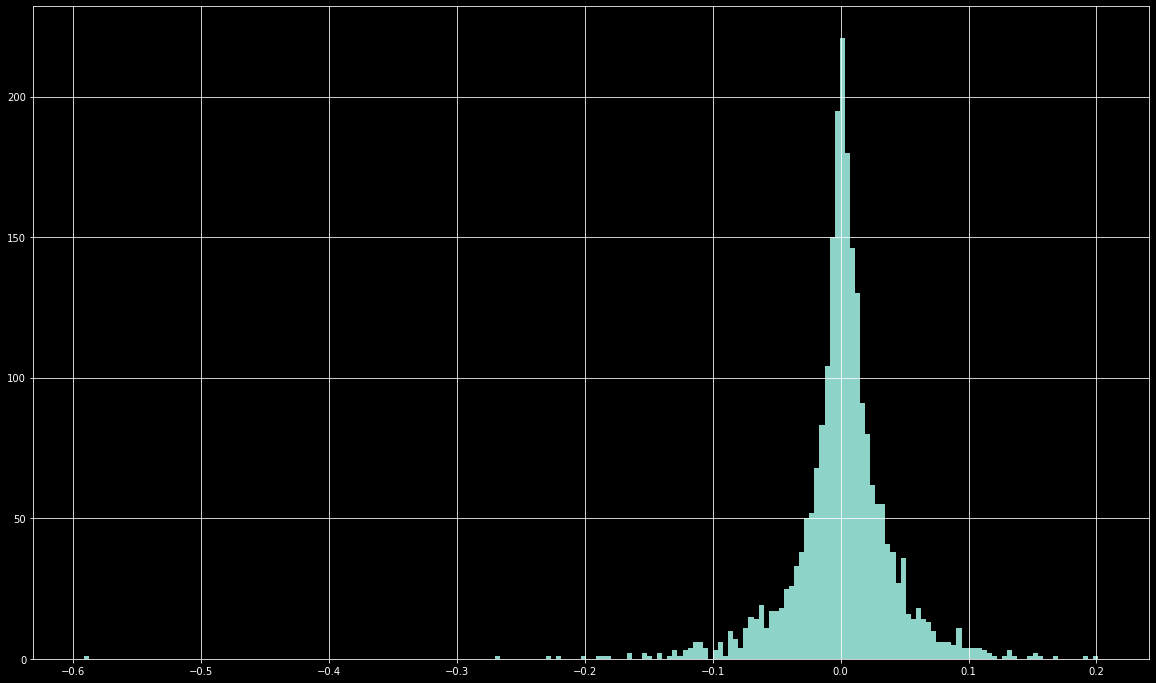

In [36]:
# plot histogram for log returns
plt.subplots(figsize = (20,12))
df['return'].dropna().hist(bins=200)

In [37]:
print("RETURN-MEAN: ", df['return'].mean())
print("RETURN-STDEV: ", df['return'].std())

RETURN-MEAN:  0.001207235856619096
RETURN-STDEV:  0.04024249090077105


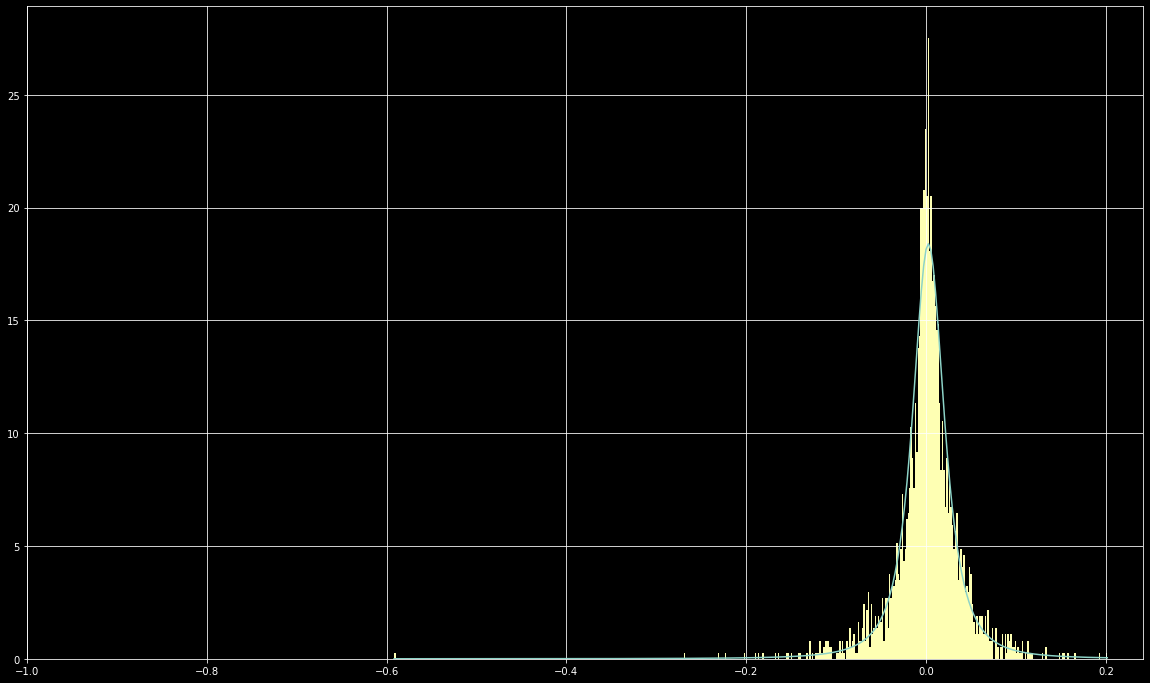

In [38]:
x_sample = np.linspace(df['return'].min(), df['return'].max(), 300)
t_params = tstudent.fit(df['return'].dropna())
t_df, t_loc, t_scale = t_params
y_distr = tstudent.pdf(x_sample, t_df, t_loc, t_scale)
plt.subplots(figsize = (20,12))
plt.plot(x_sample, y_distr)
plt.xlim(left=-1)
df['return'].hist(bins=500, density=True)


In [105]:
# my qq-plot function and cut edge data points function 

def my_qq(my_return, n_points):
  dist_t_params = tstudent.fit(my_return.dropna())
  sample = np.linspace(my_return.min(), my_return.max(), len(my_return.dropna()))
  t_pdf = tstudent.pdf(sample, dist_t_params[0], dist_t_params[1], dist_t_params[2])

  x = []
  y = []
  simulation = []

  for _ in range(len(my_return.dropna())):
    simulation.append(tstudent.rvs(dist_t_params[0], dist_t_params[1], dist_t_params[2]))

  p_list = np.linspace(0, 1, n_points)
  df = pd.DataFrame({'data': my_return.dropna().copy(), 'simulation' : simulation })

  for p in p_list:
    y.append(df['data'].quantile(p))
    x.append(df['simulation'].quantile(p))

  return x,y

def my_qq_plot(my_data, frac_list, n_points):
  n = len(frac_list)
  plt.subplots(figsize=(40,6))
  for i in range(n):
    plt.subplot(1, n, i+1)
    data_ = cut_edge_data(my_data, frac_list[i])
    x,y = my_qq(data_['return'], n_points)
    plt.plot(x,y, 'o',label = f"data cut by  {2 * frac_list[i] * 100} %")
    plt.plot(x,x)
    plt.legend()
    plt.grid()
    

def cut_edge_data(my_data, frac):
    if 'return' in my_data.columns:
      my_data_cut = pd.DataFrame(my_data['return'].dropna().copy())
      my_data_cut = my_data_cut[my_data_cut['return']>my_data_cut['return'].quantile(frac)]
      my_data_cut = my_data_cut[my_data_cut['return']<my_data_cut['return'].quantile(1-frac)]
      return my_data_cut
    else:
      raise ValueError('No "return" in columns.')


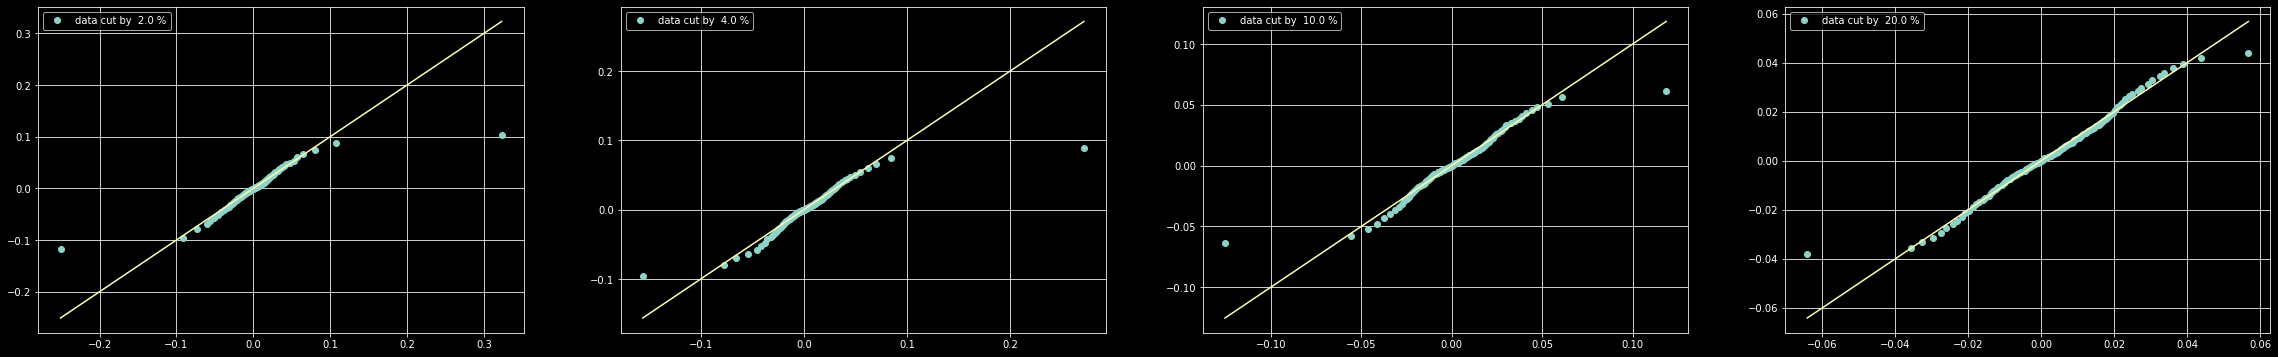

In [106]:
my_qq_plot(df, [0.01, 0.02, 0.05, 0.1], 100)

In [ ]:
close_prices = df['Close'].copy()

In [127]:
def plot_stats(my_data, last_steps):
  plot_data = pd.DataFrame(my_data['return'][-last_steps:].copy())
  plot_data['slow_sma'] = plot_data['return'].rolling(10).mean()
  plot_data['mid_sma'] = plot_data['return'].rolling(30).mean()
  plot_data['fast_sma'] = plot_data['return'].rolling(7).mean()
  plot_data[['return', 'slow_sma', 'mid_sma', 'fast_sma']].plot(figsize=(40,10))
  plt.legend()
  plt.grid()



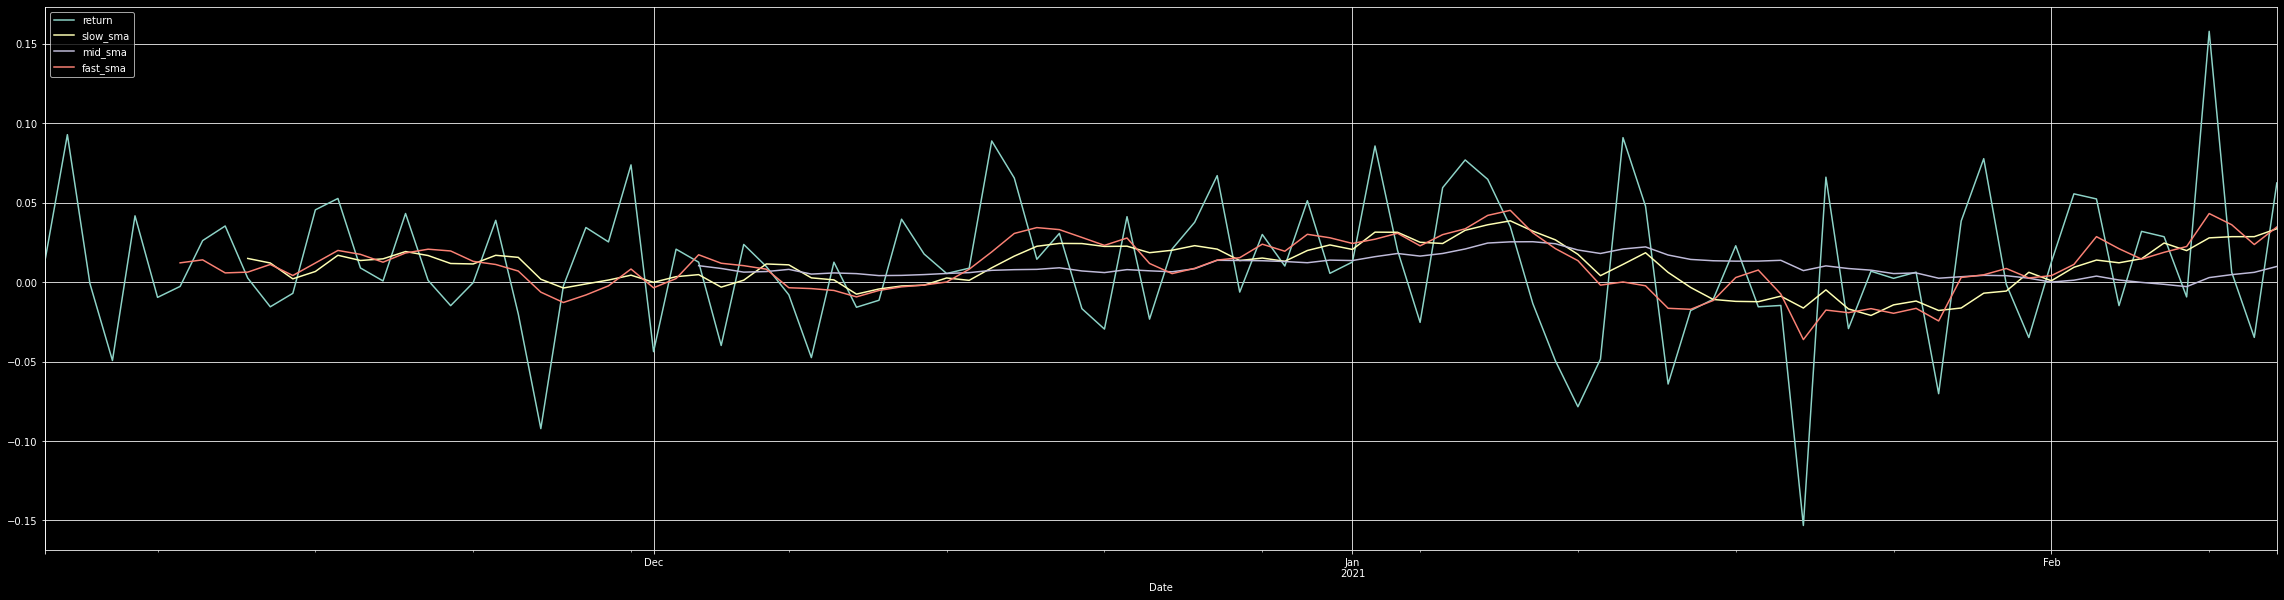

In [128]:
plot_stats(df,100)

# **2. Machine learning part**

work in progres....

In [ ]:
def input_data_generator(data_frame = None, window_size = 40, forecast_size = 10, up_trend = 0.25 ):
  ''' 
    Prepare raw market data for CNN.
    Inputs: 
      data_frame: pandas.DataFrame object containing market data of given asset (BTC-USD, ETH-USD, etc.)
      window_size: length of time-series for which you want to find a pattern
      forecast_size: length of forecast time-series ( we want to give linear trend for next forecast_size points)

  '''
  X = []
  Y = []
  N = data_frame.shape[0]
  i = 0
  while (i + window_size + forecast_size < N):
    x = []
    for col in data_frame.columns:
      preprocess = np.array(data_frame[col].values[i : i + window_size ])
      postprocess = (preprocess - preprocess.mean()) / preprocess.std()
      x.append(postprocess)
    X.append(x)

    m_1 = (data_frame['Open'].values[i + window_size ] + data_frame['Close'].values[i + window_size] ) / 2
    m_2 = (data_frame['Open'].values[i + window_size + forecast_size] + data_frame['Close'].values[i + window_size + forecast_size]) / 2
    trend = (m_2 - m_1) / m_1
    if trend > up_trend:
      Y.append(1)
    else:
      Y.append(0)

    i += 1
  X = np.array(X)
  X = X.reshape(X.shape[0], X.shape[2], X.shape[1])
  Y = np.array(Y)
  return [X, Y]





In [ ]:
[X, Y] = input_data_generator(df, window_size = 40)

In [ ]:
ind = int(X.shape[0] * 0.75)
x_train, x_test = X[:ind], X[ind:]
y_train, y_test = Y[:ind], Y[ind:]

In [ ]:
i = Input(shape = x_train[0].shape)
x = Conv1D(32, 3, activation = 'relu')(i)
x = BatchNormalization()(x)
x = Conv1D(32, 3, activation = 'relu')(x)
x = MaxPool1D(pool_size = 2)


x = Conv1D(64, 3, activation = 'relu')(i)
x = BatchNormalization()(x)
x = Conv1D(64, 3, activation = 'relu')(x)
#x = MaxPool1D(pool_size = 2)(x)


x = Flatten()(x)
x = Dense(64, activation = 'relu')(x)
x = Dropout(0.1)(x)
x = Dense(2, activation = 'softmax')(x)
model =  Model(i, x)

In [ ]:
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
r = model.fit(x_train, y_train, validation_data = (x_test, y_test), epochs = 10)

In [ ]:
plt.plot(r.history['loss'], label = 'loss')
plt.plot(r.history['val_loss'], label = 'val_loss')
plt.legend()
plt.grid()

In [ ]:
plt.plot(r.history['accuracy'], label = 'accuracy')
plt.plot(r.history['val_accuracy'], label = 'val_accuracy')
plt.legend()
plt.grid()